# HW 4
written by JungYoung<br/>
Last updated, 201017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import ElecField_mc as em
import tqdm

In [29]:
class SolveODE_elec:
    def __init__(self, pos, rhos, vol, target_q):
        self.rhos = rhos
        self.pos = pos
        self.vol = vol
        self.target_q = target_q

    def F_e(self, x):
        return self.target_q * em.get_elecfield(self.pos, self.rhos, x.reshape(2, 1), vol=self.vol, k=1)[:, 0]

    def f(self, x, v, F):
        # dv/dt = F(x)
        # dx/dt = v
        dv = self.F_e(x)*self.dt
        dx = (v+dv)*self.dt
        return dx, dv

    def solve(self, x, v, tmax, rmax=None, dt=0.01):
        itr = int(tmax/dt)
        self.x = np.array(x)
        self.v = np.array(v)
        self.dt = dt
        self.xs = [self.x.copy()]
        self.vs = [self.v.copy()]
        pbar = tqdm.tqdm(range(itr), ncols=100)
        for i in pbar:
            self.update()
            self.xs.append(self.x.copy())
            self.vs.append(self.v.copy())
            if rmax is not None and np.sqrt(sum(self.x**2)) <= rmax:
                print('\ncollision occur!')
                pbar.close()
                break

    def update(self):
        # use RK4 method
        kdx1, kdv1 = self.f(self.x, self.v, self.F_e(self.x))
        kdx2, kdv2 = self.f(self.x+kdx1/2, self.v+kdx1/2, self.F_e(self.x+kdx1/2))
        kdx3, kdv3 = self.f(self.x+kdx2/2, self.v+kdv2/2, self.F_e(self.x+kdx2/2))
        kdx4, kdv4 = self.f(self.x+kdx3, self.v+kdv3, self.F_e(self.x+kdx3))
        self.x += kdx1/6+kdx2/3+kdx3/3+kdx4/6
        self.v += kdv1/6+kdv2/3+kdv3/3+kdv4/6
        

class PickRand(em.mcSampling):
    def frho(self, r):
        # k*|r|**2
        return 2*sum(r**2)

    def fboundary(self, r):
        # rmax = 1
        return np.sqrt(sum(r**2)) <= 1
    

In [3]:
# get electric field 
seed = 100010
rmax = 1
rlim = [[-rmax, rmax], [-rmax, rmax]]
itr = 1e5
vol = np.pi*rmax**2 / itr
mc_obj = PickRand(rlim, ndim=2, seed=seed)

In [4]:
pts, rho = mc_obj.get_rand_pts(itr=int(itr))

100%|████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 38094.77it/s]


In [5]:
ode_obj = SolveODE_elec(pts, rho, vol, -1)

In [6]:
# initial condition
# set x = [10, 0]
# set v = [0, 0]
x_init = [0., 5.]
v_init = [0., 0]
ode_obj.solve(x_init, v_init, 10, rmax, dt=0.001)

 64%|█████████████████████████████████████▎                    | 6435/10000 [11:33<06:24,  9.28it/s]
collision occur!



In [7]:
ode_obj.v

array([ 2.58415623, -5.35131073])

In [23]:
ode_obj.xs[0]

array([0.12730439, 0.98827376])

In [17]:
ode_obj.F_e(ode_obj.x)

array([ 0.00278949, -0.00151351])

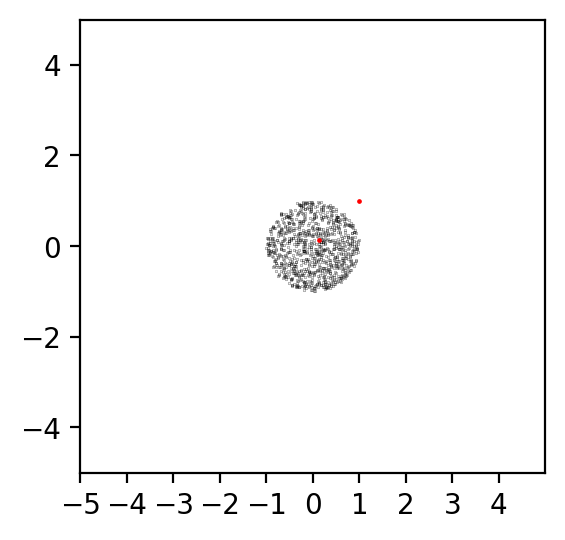

In [14]:
# create image
n = 1

plt.figure(dpi=200, figsize=(3, 3))
plt.scatter(pts[0, :1000], pts[1, :1000], 0.01, c='k')
plt.scatter(ode_obj.xs[0], ode_obj.xs[1], 0.5, c='r')
# plt.xlim([-x_init[0], x_init[0]])
# plt.ylim([-x_init[0], x_init[0]])
plt.ylim([-5, 5])
plt.xlim([-5, 5])
# plt.xticks(range(5))
plt.xticks(np.arange(-5, 5))
# plt.grid(True)
plt.show()

In [21]:
ode_obj.xs[1][0]

0.12730438634961666

In [ ]:
w = 0.5
x_nears = np.linspace(x_init[])